# Exploration 10

## 모듈 불러오기

In [36]:
!pip install imageio
!pip install Pillow

In [37]:
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

print("tensorflow", tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
tensorflow 2.7.0


## 데이터셋 구성하기

CIFAR-10 데이터셋 구성

In [38]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape

(50000, 32, 32, 3)

- 학습에 사용 할 `train_x`의 이미지를 -1, 1로 정규화 합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 from_tensor_slices()함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [39]:
print("Max Pixcel: ", train_x.max())
print("min Pixcel: ", train_x.min())

Max Pixcel:  255
min Pixcel:  0


train_x 의 이미지를 -1, 1로 정규화

In [40]:
dtrain_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화

In [41]:
print("Max Pixcel: ", train_x.max())
print("min Pixcel: ", train_x.min())

Max Pixcel:  255
min Pixcel:  0


In [42]:
train_x.shape

(50000, 32, 32, 3)

로드한 데이터를 시각화를 통해 확인

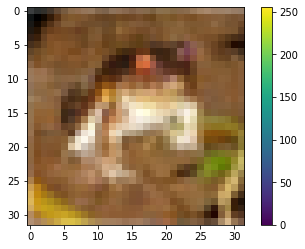

In [43]:
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

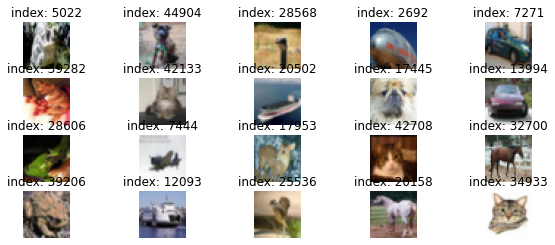

In [44]:
plt.figure(figsize=(10, 5))

for i in range(20):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

- tf.data.Dataset 모듈의 from_tensor_slices()함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [45]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [46]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [47]:
# # 학습시간이 오래걸린다면 아래 함수 참고
# def load_data(label = None):
#     (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
#     if label:
#         df = pd.DataFrame(list(zip(train_x, train_y)), columns = ['image', 'label'])
#         df = df[df['lavel']==label]
#         train_x = np.array([i for i in list(df['image'])])
#         df = pd.DataFrame(list(zip(train_x, train_y)), columns = ['image', 'label'])
#         df = df[df['label']==label]
#         test_x = np.array([i for i in list(df['image'])])
#     return train_x, test_x

## 생성자 모델 구현하기

- (32, 32, 3)의 shape을 가진 이미지 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- `noise = tf.random.normal([1, 100])`로 생성된 랜덤 노이지를 입력으로 하여 방금 구성한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

(32, 32, 3)의 shape을 가진 이미지 생성하는 생성자 모델 구현 함수 작성해 보기.

In [48]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='ReLU'))

    return model

noise = tf.random.normal([1, 100])로 생성된 랜덤 노이지를 입력하여 방금 구성한 생성자로 랜덤 이미지 생성해보기.

In [49]:
generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_3 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)       

In [50]:
noise = tf.random.normal([1,100])

In [51]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

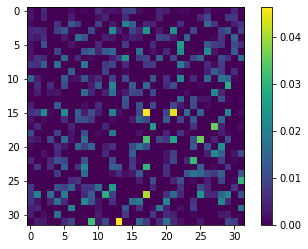

In [52]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## 판별자 모델 구현하기

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 "데이터 구성하기"에서 생성한 랜덤 이미지를 판별자 모델이 판결한 결과값을 확인해 봅시다.

In [53]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [54]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)             

위에서 생성했던 랜덤 이미지를 판별자 모델이 판별한 결과 값을 확인해보기

In [55]:
decision = discriminator(generated_image, training = False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00059446]], dtype=float32)>

## 손실함수와 최적화 함수 구현하기

- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

교차 엔트로피 함수

In [56]:
# 교차 엔트로피 함수
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

generator(생성자)는 fake_output(자신의 가짜 이미지)이 1에 가까워 지기를 바라므로 `tf.ones_like` 를 사용한다.

In [57]:
# generator_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

반대로, discriminator(판별자)는 real_output(진짜 이미지)이 1에 가까워 지기를, fake_output(생성해 낸 이미지)이 0에 가까워 지기를 바라므로 loss값을 모두 계산한다.

In [58]:
# discriminator_loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


판별자가 real output, fake output을 얼마나 정확하게 판별하는지를 계산하는 accuracy

- 1. `tf.math.greater_equal(real_ouput, tf.constant([0.5])`: output의 각 원소가 0.5 이상인지 True / False로 판별함.
- 2. `tf.cast( 위의결과, tf.float32)`: Ture -> 1.0, False -> 0.0
- 3. `tf.reduce_mean( 2번 )`: 2번의 결과를 평균을 내어 정확도 (accuracy) 계산.

In [59]:
# discriminator_accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

최적화 함수(optimizer)
- 생성자와 구분자는 개별 네트워크 이기 때문에 optimizer를 따로 만든다.

In [60]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

학습이 어떻게 진행되는지 확인하기 위해 생성자가 샘플 확인
- 한번에 16장 생성
100차원의 노이즈를 총 16개

In [61]:
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련과정 상세 기능 구현하기

- 1개 미니배치의 훈련과정을 처리하는 `train_step()`함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화 하는 `generate_and_save_images()` 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화 하는 `draw_train_histoty` 함수를 구현해 봅시다.
- `training_checkpoints` 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint모듈을 설정해 봅시다.


train_step 함수 구현하기
- (1) 입력 데이터: Real Image 한 세트를 입력받음.
- (2) 생성자 입력 노이즈: generator가 Fake Image를 생성하기 위한 `noise`를 `images` 한 세트와 같은 크기인 `BATCH_SIZE` 만큼 생성.
- (3) `tf.GradientTape()`는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 `with` 구문 열기.
- (4) generated_images 생성: generator가 `noise`를 입력받은 후 `generated_images` 생성.
- (5) discriminator 판별: discriminator가 Real Image인 `images`와 Fake Image인 `generated_images`를 각각 입력받은 후 `real_output`, `fake_output` 출력.
- (6) loss 계산: `fake_output`, `real_output`으로 generator와 discriminator 각각의 loss 계산.
- (7) accuracy 계산: `fake_output`, `real_output`으로 discriminator의 정확도 계산.
- (8) gradient 계산: `gen_tape`와 `disc_tape`을 활용 해 gradient를 자동으로 계산.
- (9) 모델 학습: 계산된 gradient를 optimizer에 압력해 가중치 갱신.
- (10) 리턴값: 이번 스텝에 계산된 loss와 accuracy를 리턴.


In [62]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

학습 현황을 볼 수 있는 샘플을 생성하는 함수.
- 고정된 seed를 이용하여 결과물을 만들어 내므로, 고정된 seed에 대한 결과물이 얼마나 나아지는지 확인할 수 있다.

In [63]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training = False)

    fig = plt.figure(figsize = (4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
    
    plt.savefig('/content/drive/MyDrive/LMS/Exploration/Ex.10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))

    plt.show()

`gen_loss`, `disc_loss`, `real_accuracy`, `fake_accuracy` 값을 가지는 history 라는 dict 구조로 매 에포크마다 저장하는 함수 만들기

In [64]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6 # matlab 차트의 기본 크기인 15,6 지정.

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc = 'upper left')

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/LMS/Exploration/Ex.10/training_history/training_history_{:04d}.png'.format(epoch))

    plt.show()

Checkpoint 만들기.
- 모델이 복잡하고 학습 속도가 오래걸릴 수록 필수적이다.
- checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장해준다.
- 정확하게는, 생성자와 판별자가 학습한 모델 가중치를 저장하는 것.

In [65]:
checkpoint_dir = '/content/drive/MyDrive/LMS/Exploration/Ex.10/training_checkpoints'

checkpoint_prefix = checkpoint_dir + "/ckpt"
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)


## 학습 과정 진행하기

- 위 "손실함수와 최적화 함수 구현하기" 에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만들 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif파일, 학습 진행 그래프 이미지를 함께 제출합니다.

####참고
학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때 마다 모델 학습을 처음부터 다시 진행하면 시간 낭비가 될 것입니다.
우리는 위에서 checkpoint모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
아래는 checkpoint모듈을 활용하여 모델을 로드하는 예시입니다.

위의 함수들을 이용하여 학습 함수 만들기

In [66]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 ==0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print("Epoch {} | iter {}".format(epoch+1, it+1))
                print("Time for epoch {}: {} sec".format(epoch+1, int(time.time()-epoch_start)))
        
        if (epoch +1) % save_every == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training: {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [67]:
save_every = 10
EPOCHS = 50

# 사용 가능한 GPU 확인
tf.config.list_physical_devices("GPU")

[]

학습시작

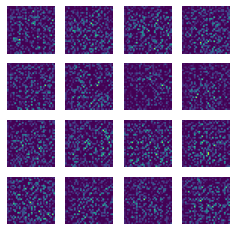

Epoch 1 | iter 1
Time for epoch 1: 30 sec


KeyboardInterrupt: ignored

In [68]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 /training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [ ]:
anim_file = '/content/drive/MyDrive/LMS/Exploration/Ex.10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/LMS/Exploration/Ex.10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/LMS/Exploration/Ex.10/fashion_mnist_dcgan.gif

## GAN훈련 과정 개선하기